In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive


In [0]:
from fastai import *
from fastai.vision import *
import pandas as pd
import matplotlib.image as mpimg
from fastai.utils.ipython import *
from fastai.metrics import *
from fastai.callbacks.tracker import SaveModelCallback

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import skimage.data
import skimage.color
from skimage.transform import rescale, resize
import scipy.misc
import scipy.signal
import time

import torch
torch.manual_seed(0)
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import models
import torchvision.transforms as transforms

from matplotlib import rcParams
rcParams['axes.grid'] = False

import warnings
warnings.filterwarnings("ignore")

In [0]:
import pickle

img_size = 32
# load from pickle file
if img_size == 32:
  train_x = pickle.load( open( "/content/gdrive/My Drive/train_x32.p", "rb" ) )
  valid_x = pickle.load( open( "/content/gdrive/My Drive/valid_x32.p", "rb" ) )
  test_x = pickle.load( open( "/content/gdrive/My Drive/test_x32.p", "rb" ) )
if img_size == 48:
  train_x = pickle.load( open( "/content/gdrive/My Drive/train_x48.p", "rb" ) )
  valid_x = pickle.load( open( "/content/gdrive/My Drive/valid_x48.p", "rb" ) )
  test_x = pickle.load( open( "/content/gdrive/My Drive/test_x48.p", "rb" ) )

train_y = pickle.load( open( "/content/gdrive/My Drive/train_y.p", "rb" ) )
valid_y = pickle.load( open( "/content/gdrive/My Drive/valid_y.p", "rb" ) )
test_y = pickle.load( open( "/content/gdrive/My Drive/test_y.p", "rb" ) )

In [0]:
print(train_x.shape)
print(valid_x.shape)

torch.Size([2592, 3, 32, 32])
torch.Size([648, 3, 32, 32])


In [0]:
assert torch.cuda.is_available()

In [0]:
RGB_train_x = train_x.cuda()
RGB_valid_x = valid_x.cuda()
test_x = test_x.cuda()

In [0]:
import torchvision

NUM_CLASSES = 2
GRAY_CHANNEL = 1
RGB_CHANNELS = 3
HEIGHT = 32
WIDTH = 32

In [0]:
def batch(batch_size, images, labels, training=True):
  """Create a batch of examples.
  
  This creates a batch of input images and a batch of corresponding
  ground-truth labels. We assume CUDA is available (with a GPU).
  
  Args:
    batch_size: An integer.
    images: images to train on
    labels: class labels of each image
    training: A boolean. If True, grab examples from the training
      set; otherwise, grab them from the validation set.
  
  Returns:
    A tuple,
    input_batch: A Variable of floats with shape
      [batch_size, 1, height, width]
    label_batch: A Variable of ints with shape
      [batch_size].
  """
  if training:
    #TODO: 3. set fixed indices to see if model will overfit as expected
    random_ind = np.random.choice(images.shape[0], size=batch_size, replace=False)
    input_batch = images[random_ind]
    label_batch = labels[random_ind]
  else:
    input_batch = images[:batch_size]
    label_batch = labels[:batch_size]
  
  input_batch = torch.tensor(input_batch, requires_grad=False, device='cuda')
  label_batch = torch.tensor(label_batch, requires_grad=False, device='cuda')
  
  return input_batch, label_batch

In [0]:
def train_step(model, train_images, train_labels, optimizer, batch_size=128):
  """Conducts one training iteration
  
  Trains on one batch of input images, computes loss, and back propagates.
  
  Args:
    model: network
    train_images: images used for training
    train_labels: class labels for each training image
    optimizer: type of optimization
    batch_size: an integer
  
  Returns:
    loss, error
  """
  model.train()

  input_batch, label_batch = batch(batch_size, train_images, train_labels, training=True)
  input_batch = input_batch.float()
  output_batch = model(input_batch)
  loss = F.cross_entropy(output_batch, label_batch)
  _, pred_batch = torch.max(output_batch, dim=1)
  error_rate = 1.0 - (pred_batch == label_batch).float().mean()

  optimizer.zero_grad()
  loss.backward()
  
  optimizer.step()
  
  return loss.item(), error_rate.item()

In [0]:
def val(model, val_images, val_labels):
  """Conducts validation step

  Passes validation images through model, computes loss, and error rate.
  
  Args:
    model: network
    val_images: images used for validation
    val_labels: class labels for validation images
  
  Returns:
    loss, error
  """
  
  model.eval()
  input_batch, label_batch = batch(val_images.shape[0], val_images, val_labels, training=False)
  input_batch = input_batch.float()
  #TODO: 4. visualize input_batch -- what goes directly into model
  output_batch = model(input_batch)

  loss = F.cross_entropy(output_batch, label_batch)
  _, pred_batch = torch.max(output_batch, dim=1)
  error_rate = 1.0 - (pred_batch == label_batch).float().mean()
  
  return loss.item(), error_rate.item()

In [0]:
def train(name, model, optimizer, train_images, train_labels, val_images, val_labels, num_steps, num_steps_per_val):
  """Executes entire training procedure.
  
  Iterates through each step, number of steps determined by user.
  Plots training, validation loss and training, validation error.
  
  Args:
    model: network
    optimizer: type of optimization
    train_images: images used for training
    train_labels: class labels for training images
    val_images: images used for validation
    val_labels: class labels for validation images
    num_steps: number of iterations
    num_steps_per_val: determines how often validation is done
  
  Returns:
    None
  """
  #TODO: 1. initialization
  for module in model.children():
    if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
      module.reset_parameters()
    if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
      torch.nn.init.xavier_uniform_(module.weight.data)

  info = []
  fig, ax = plt.subplots(2, 1, sharex=True)
  best_val_err = 1.0
  best_val_loss = np.inf
  for step in range(num_steps):
    # TODO: 7. smaller batch size
    train_loss, train_err = train_step(model, train_images, train_labels, optimizer)
    if step % num_steps_per_val == 0:
      val_loss, val_err = val(model, val_images, val_labels)
      if val_err < best_val_err:
        best_val_err = val_err
        torch.save(model, '/content/gdrive/My Drive/' + name + str(img_size))
        print('Step {:5d}: Obtained a best validation error of {:.3f}.'.format(step, best_val_err))
      elif val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model, '/content/gdrive/My Drive/' + name + str(img_size))
      info.append([step, train_loss, val_loss, train_err, val_err])
      print('Step {:5d}: Train Error - {:.3f}, Val Error - {:.3f}, Train Loss - {:.3f}, Val Loss - {:.3f}.'.format(step, train_err, val_err, train_loss, val_loss))
      x, y11, y12, y21, y22 = zip(*info)
      ax[0].plot(x, y11, c='r')
      ax[0].plot(x, y12, c='g')
      ax[0].legend(['Train loss', 'Val loss'])
      ax[1].plot(x, y21, c='r')
      ax[1].plot(x, y22, c='g')
      ax[1].legend(['Train err', 'Val err'])
      ax[1].set_ylim([0.0, 1.0])

In [0]:
def evaluate(m_loaded):
  for m in m_loaded.modules():
      if m.__class__.__name__.startswith('Dropout'):
        m.train()

  output = []
  for i in range(len(test_x)):
    result = m_loaded(test_x[i:i+1,:,:,:].float())
    _, pred_batch = torch.max(result, dim=1)
    output = output + pred_batch.cpu().data.numpy().tolist()

  # baseline accuracy - 89%
  wrong = 0
  # print(output)
  # print(test_y)
  for i in range(len(output)):
    if output[i] != test_y[i]:
      wrong = wrong + 1
  print(1.0 - wrong/len(output))

In [0]:
class Unit(torch.nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Unit,self).__init__()
        
        self.conv1 = torch.nn.Conv2d(in_channels=in_channels,kernel_size=3,out_channels=out_channels,stride=1,padding=3//2)
        self.bn = torch.nn.BatchNorm2d(num_features=out_channels)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self,input):
        output = self.conv1(input)
        output = self.bn(output)
        output = self.dropout(output)
        output = self.relu(output)

        return output

class model1(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.unit1 = Unit(in_channels=3,out_channels=64) # 64*32*32
    self.unit6 = Unit(in_channels=64,out_channels=64) # 64*32*32

    self.pool1 = torch.nn.MaxPool2d(kernel_size=2)

    self.unit2 = Unit(in_channels=64, out_channels=128) # 128*16*16
    self.unit3 = Unit(in_channels=128, out_channels=128) # 128*16*16

    self.pool2 = torch.nn.MaxPool2d(kernel_size=2)

    self.unit4 = Unit(in_channels=128, out_channels=128) # 128*8*8
    self.unit7 = Unit(in_channels=128, out_channels=128) # 128*8*8

    self.pool3 = torch.nn.MaxPool2d(kernel_size=2)

    self.unit5 = Unit(in_channels=128, out_channels=128) # 128*4*4

    self.avgpool = torch.nn.AvgPool2d(kernel_size=4)

    self.net = torch.nn.Sequential(self.unit1, self.unit6, self.pool1,
                                   self.unit2, self.unit3, self.pool2,
                                   self.unit4, self.unit7, self.pool3,
                                   self.unit5, self.avgpool)  

    self.fc_extra = torch.nn.Linear(in_features=256,out_features=128) # 128
    self.fc = torch.nn.Linear(in_features=128,out_features=NUM_CLASSES) # 2

  def forward(self, input):
    output = self.net(input)
    output = output.view(-1,128)
    # output = self.fc_extra(output)
    output = self.fc(output)
    return output

In [0]:
# Number of neurons
print(64*32*32*2+128*16*16*2+128*8*8*2+128*4*4+130)

# Number of parameters - 9C^2


215170


Step     0: Obtained a best validation error of 0.957.
Step     0: Train Error - 0.461, Val Error - 0.957, Train Loss - 0.712, Val Loss - 0.776.
Step   100: Obtained a best validation error of 0.940.
Step   100: Train Error - 0.062, Val Error - 0.940, Train Loss - 0.144, Val Loss - 1.460.
Step   200: Obtained a best validation error of 0.343.
Step   200: Train Error - 0.031, Val Error - 0.343, Train Loss - 0.104, Val Loss - 0.604.
Step   300: Obtained a best validation error of 0.045.
Step   300: Train Error - 0.047, Val Error - 0.045, Train Loss - 0.137, Val Loss - 0.227.
Step   400: Obtained a best validation error of 0.042.
Step   400: Train Error - 0.008, Val Error - 0.042, Train Loss - 0.035, Val Loss - 0.156.
Step   500: Train Error - 0.023, Val Error - 0.042, Train Loss - 0.046, Val Loss - 0.169.
Step   600: Train Error - 0.008, Val Error - 0.042, Train Loss - 0.051, Val Loss - 0.125.
Step   700: Train Error - 0.000, Val Error - 0.043, Train Loss - 0.015, Val Loss - 0.179.
Step 

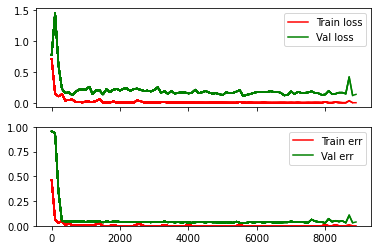

In [0]:
m = model1()
m.cuda()
optimizer1 = torch.optim.Adam(m.parameters(), lr=0.001, weight_decay=0.0000001)
train('simp_model1_', m, optimizer1, RGB_train_x, train_y, RGB_valid_x, valid_y, 9000, 100)

In [0]:
m_loaded = torch.load("/content/gdrive/My Drive/simp_model1_"+str(img_size))
m_loaded.eval()
evaluate(m_loaded)

In [0]:
class Unit2(torch.nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Unit2,self).__init__()
        
        self.conv = torch.nn.Conv2d(in_channels=in_channels,kernel_size=3,out_channels=out_channels,stride=1,padding=3//2)
        self.bn = torch.nn.BatchNorm2d(num_features=out_channels)
        self.relu = torch.nn.ReLU()

    def forward(self,input):
        output = self.conv(input)
        output = self.bn(output)
        output = self.relu(output)

        return output

class model2(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.unit1 = Unit2(in_channels=3,out_channels=32) # 32*32*32
    self.unit2 = Unit2(in_channels=32, out_channels=32) # 32*32*32
    self.unit3 = Unit2(in_channels=32, out_channels=32) # 32*32*32

    self.pool1 = torch.nn.MaxPool2d(kernel_size=2)

    self.unit4 = Unit2(in_channels=32, out_channels=64) # 64*16*16
    self.unit5 = Unit2(in_channels=64, out_channels=64) # 64*16*16
    self.unit6 = Unit2(in_channels=64, out_channels=64) # 64*16*16

    self.pool2 = torch.nn.MaxPool2d(kernel_size=2)

    self.unit8 = Unit2(in_channels=64, out_channels=128) # 128*8*8
    self.unit9 = Unit2(in_channels=128, out_channels=128) # 128*8*8
    self.unit10 = Unit2(in_channels=128, out_channels=128) # 128*8*8

    self.pool3 = torch.nn.MaxPool2d(kernel_size=2)

    self.unit12 = Unit2(in_channels=128, out_channels=128) # 128*4*4
    self.unit13 = Unit2(in_channels=128, out_channels=128) # 128*4*4
    self.unit14 = Unit2(in_channels=128, out_channels=128) # 128*4*4

    self.avgpool = torch.nn.AvgPool2d(kernel_size=4)

    self.net = torch.nn.Sequential(self.unit1, self.unit2, self.unit3,
                                   self.pool1, self.unit4, self.unit5,
                                   self.unit6, self.pool2, self.unit8,
                                   self.unit9, self.unit10, self.pool3,
                                   self.unit12, self.unit13, self.unit14,
                                   self.avgpool)  

    self.fc = torch.nn.Linear(in_features=128,out_features=NUM_CLASSES) # 2

  def forward(self, input):
    output = self.net(input)
    output = output.view(-1,128)
    output = self.fc(output)
    return output

Step     0: Obtained a best validation error of 0.957.
Step     0: Train Error - 0.703, Val Error - 0.957, Train Loss - 0.982, Val Loss - 0.699.
Step   100: Obtained a best validation error of 0.097.
Step   100: Train Error - 0.070, Val Error - 0.097, Train Loss - 0.187, Val Loss - 0.356.
Step   200: Train Error - 0.070, Val Error - 0.349, Train Loss - 0.153, Val Loss - 0.658.
Step   300: Train Error - 0.062, Val Error - 0.171, Train Loss - 0.125, Val Loss - 0.572.
Step   400: Train Error - 0.023, Val Error - 0.310, Train Loss - 0.103, Val Loss - 0.751.
Step   500: Train Error - 0.062, Val Error - 0.261, Train Loss - 0.157, Val Loss - 0.802.
Step   600: Train Error - 0.102, Val Error - 0.207, Train Loss - 0.242, Val Loss - 0.676.
Step   700: Train Error - 0.031, Val Error - 0.119, Train Loss - 0.087, Val Loss - 0.392.
Step   800: Train Error - 0.016, Val Error - 0.492, Train Loss - 0.057, Val Loss - 1.870.
Step   900: Train Error - 0.008, Val Error - 0.378, Train Loss - 0.041, Val Loss

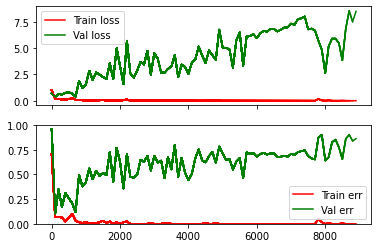

In [0]:
m2 = model2()
m2.cuda()
optimizer2 = torch.optim.Adam(m2.parameters(), lr=0.003, weight_decay=0.0000001)
train("ablation1_", m2, optimizer2, RGB_train_x, train_y, RGB_valid_x, valid_y, 9000, 100)

In [0]:
m_loaded2 = torch.load("/content/gdrive/My Drive/ablation1_"+str(img_size))
m_loaded2.eval()
evaluate(m_loaded2)

In [0]:
class Unit3(torch.nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Unit3,self).__init__()
        
        self.conv = torch.nn.Conv2d(in_channels=in_channels,kernel_size=7,out_channels=out_channels,stride=1,padding=7//2)
        self.bn = torch.nn.BatchNorm2d(num_features=out_channels)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self,input):
        output = self.conv(input)
        output = self.bn(output)
        output = self.dropout(output)
        output = self.relu(output)

        return output

class model3(torch.nn.Module):
    def __init__(self):
    super().__init__()
    self.unit1 = Unit3(in_channels=3,out_channels=32) # 32*32*32
    self.unit2 = Unit3(in_channels=32, out_channels=32) # 32*32*32
    self.unit3 = Unit3(in_channels=32, out_channels=32) # 32*32*32

    self.pool1 = torch.nn.MaxPool2d(kernel_size=2)

    self.unit4 = Unit3(in_channels=32, out_channels=64) # 64*16*16
    self.unit5 = Unit3(in_channels=64, out_channels=64) # 64*16*16
    self.unit6 = Unit3(in_channels=64, out_channels=64) # 64*16*16

    self.pool2 = torch.nn.MaxPool2d(kernel_size=2)

    self.unit8 = Unit3(in_channels=64, out_channels=128) # 128*8*8
    self.unit9 = Unit3(in_channels=128, out_channels=128) # 128*8*8
    self.unit10 = Unit3(in_channels=128, out_channels=128) # 128*8*8

    self.pool3 = torch.nn.MaxPool2d(kernel_size=2)

    self.unit12 = Unit3(in_channels=128, out_channels=128) # 128*4*4
    self.unit13 = Unit3(in_channels=128, out_channels=128) # 128*4*4
    self.unit14 = Unit3(in_channels=128, out_channels=128) # 128*4*4

    self.avgpool = torch.nn.AvgPool2d(kernel_size=4)

    self.net = torch.nn.Sequential(self.unit1, self.unit2, self.unit3,
                                   self.pool1, self.unit4, self.unit5,
                                   self.unit6, self.pool2, self.unit8,
                                   self.unit9, self.unit10, self.pool3,
                                   self.unit12, self.unit13, self.unit14,
                                   self.avgpool)  

    self.fc = torch.nn.Linear(in_features=128,out_features=NUM_CLASSES) # 2

  def forward(self, input):
    output = self.net(input)
    output = output.view(-1,128)
    output = self.fc(output)
    return output

Step     0: Obtained a best validation error of 0.957.
Step     0: Train Error - 0.375, Val Error - 0.957, Train Loss - 0.651, Val Loss - 0.777.
Step   100: Train Error - 0.125, Val Error - 0.957, Train Loss - 0.275, Val Loss - 2.223.
Step   200: Obtained a best validation error of 0.938.
Step   200: Train Error - 0.094, Val Error - 0.938, Train Loss - 0.207, Val Loss - 1.211.
Step   300: Train Error - 0.047, Val Error - 0.946, Train Loss - 0.121, Val Loss - 1.139.
Step   400: Train Error - 0.078, Val Error - 0.957, Train Loss - 0.143, Val Loss - 1.163.
Step   500: Obtained a best validation error of 0.869.
Step   500: Train Error - 0.039, Val Error - 0.869, Train Loss - 0.105, Val Loss - 1.065.
Step   600: Train Error - 0.047, Val Error - 0.957, Train Loss - 0.131, Val Loss - 1.093.
Step   700: Train Error - 0.055, Val Error - 0.934, Train Loss - 0.122, Val Loss - 1.255.
Step   800: Train Error - 0.039, Val Error - 0.935, Train Loss - 0.110, Val Loss - 1.485.
Step   900: Train Error -

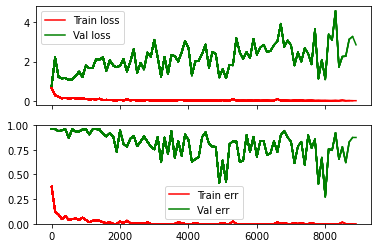

In [0]:
m3 = model3()
m3.cuda()
optimizer3 = torch.optim.Adam(m3.parameters(), lr=0.003, weight_decay=0.0000001)
train("ablation2_", m3, optimizer3, RGB_train_x, train_y, RGB_valid_x, valid_y, 9000, 100)

In [0]:
m_loaded3 = torch.load("/content/gdrive/My Drive/ablation2_"+str(img_size))
m_loaded3.eval()
evaluate(m_loaded3)